In [1]:
import os
import sys
sys.path.append('..')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from dicomhd import io as dhd_io
from medpy.io import load as load_lbl
%matplotlib inline

from tfvpc.preprocessing.two_dim import extract_2d_patch
from tfvpc.preprocessing.two_dim import show_tf_batch
from tfvpc.preprocessing.two_dim import extract_2d_patch_labels
from tfvpc.preprocessing.two_dim import extract_annotated_2d_patch


In [2]:
n_rows = 32
n_cols = 32
strides = 32

In [3]:
def recover_image(sliced_images, image_size, n_images):
    sliced_images = tf.squeeze(sliced_images)
    kernel_size = sliced_images.shape[1:3]
    steps = [(image_size[i] - kernel_size[i]) // (n_images[i] - 1) for i in range(2)]
    # Initialize image
    recovered = tf.zeros(image_size)
    mask = tf.zeros(image_size, dtype=tf.int8)
    # Kernel for counting overlaps
    kernel_ones = tf.ones(kernel_size,dtype=tf.int8)
    for j in range(n_images[0]):
        for i in range(n_images[1]):
            indexes = tf.meshgrid(tf.range(steps[0] * j, # row start
                                           kernel_size[0] + steps[0] * j), # row end
                                  tf.range(steps[1] * i, # col_start
                                        kernel_size[1] + steps[1] * i), indexing='ij') # col_end
            indexes = tf.stack(indexes, axis=-1)
            recovered = tf.tensor_scatter_nd_add(recovered, indexes, sliced_images[i+j*n_images[0]])
    return recovered


In [4]:
# Recounstarctu from patch image

def recounstruct_image(img_patch, image_size, n_images):
    img_patch = tf.squeeze(img_patch)
    kernel_size = img_patch.shape[1:3]
    steps = [(image_size[i] - kernel_size[i]) // (n_images[i] - 1) for i in range(2)]
    # Initialize image
    recounstruct = tf.zeros(image_size)
    mask = tf.zeros(image_size, dtype=tf.int8)
    # Kernel for counting overlaps
    kernel_ones = tf.ones(kernel_size,dtype=tf.int8)
    for j in range(n_images[0]):
        for i in range(n_images[1]):
            indexes = tf.meshgrid(tf.range(steps[0] * j, # row start
                                           kernel_size[0] + steps[0] * j), # row end
                                  tf.range(steps[1] * i, # col_start
                                        kernel_size[1] + steps[1] * i), indexing='ij') # col_end
            indexes = tf.stack(indexes, axis=-1)
            recounstruct = tf.tensor_scatter_nd_add(recounstruct, indexes, img_patch[i+j*n_images[0]])
    return recounstruct 

In [6]:
path_train_img = '../../data/val/input/complete/'
path_train_lbl = '../../data/val/output/complete/'
img_fname = 'groundglass-5ff7d9-Samir-2_reviewed_1-131'
lbl_fname = 'groundglass-5ff7d9-Samir-2_reviewed_1-259'


img_file_path = os.path.join(path_train_img, img_fname)
img = dhd_io.read_series(img_file_path)
# crop image
img_ann=img.pixel_data[100]
# plt.imshow(img_ann, cmap='gray')
img_ann = tf.expand_dims(img_ann, axis=0)
print(img_ann.shape)
# extract image patches
timg_patches = extract_2d_patch(img_ann, n_rows, n_cols, strides)
predicted_lbl_patches = tf.ones_like(timg_patches, dtype=tf.int64)
# predict
predicted_lbls = np.random.choice(list(range(6)), predicted_lbl_patches.shape[0], replace=True)
predicted_lbls = tf.convert_to_tensor(predicted_lbls, dtype=tf.int64)
predicted_lbl_patches = tf.reshape(predicted_lbls, [predicted_lbls.shape[0],1,1,1]) * predicted_lbl_patches
# (tf.expand_dims(tf.expand_dims(tf.expand_dims(predicted_lbls, axis=1), 1), 1) * predicted_lbl_patches)[1]
print(predicted_lbl_patches.shape)


(1, 512, 512)
(256, 32, 32, 1)


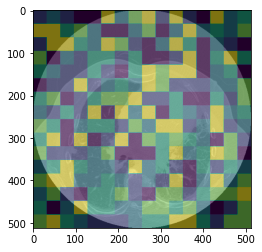

In [7]:
predicted_lbl_patches = tf.cast(predicted_lbl_patches, dtype=tf.float32)
r_blb = recover_image(predicted_lbl_patches, 
                    image_size=(512, 512), 
                    n_images=(16,16))
plt.imshow(img.pixel_data[100], cmap='gray')
plt.imshow(r_blb, alpha=0.5)

In [ ]:
# Recounstruct 2D label patch from predicted labels

In [117]:
path_train_img = '../../../data/val/input/complete/'
path_train_lbl = '../../../data/val/output/complete/'
img_fname = 'groundglass-5ff7d9-Samir-2_reviewed_1-131'
lbl_fname = 'groundglass-5ff7d9-Samir-2_reviewed_1-259'


img_file_path = os.path.join(path_train_img, img_fname)
img = dhd_io.read_series(img_file_path)
# crop image
img_ann=img.pixel_data[100]
# plt.imshow(img_ann, cmap='gray')
img_ann = tf.expand_dims(img_ann, axis=0)
print(img_ann.shape)
# extract image patches
timg_patches = extract_2d_patch(img_ann, n_rows, n_cols, strides)
patch_indices = list(range(timg_patches.shape[0]))
print(timg_patches.shape)

(1, 512, 512)
(256, 32, 32, 1)


In [118]:
# extract test patches
n_patches = timg_patches.shape[0]
test_indices = np.random.choice(n_patches, 10, replace=False).tolist() #test patches indices
background_indices = set(list(range(n_patches))).difference(set(test_indices)) 
n_test_patches = len(test_indices)


In [114]:
test_patch_labels = np.zeros(n_patches)
# predict test patches
predicted_patch_labels = np.random.randint(1, 6, n_test_patches).tolist()
# update test patch labels
test_patch_labels[test_indices, ...] = predicted_patch_labels
test_patch_labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 4., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 4.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [115]:
patch_size = (32, 32)
x = test_patch_labels
w, h = 16*patch_size[0], 16*patch_size[1]
# reshape(h, w), patch_size[1], axis=0)
patch_img = np.repeat(np.repeat(x, patch_size[0], axis=0).reshape(-1, w), patch_size[1], 0)

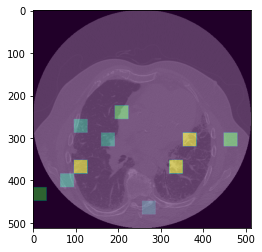

In [116]:
plt.imshow(img.pixel_data[100], cmap='gray')
plt.imshow(patch_img, alpha=0.5)

In [77]:
x = np.array([[1], [0], [3]])
np.tile(x, (2, 2))

array([[1, 1],
       [0, 0],
       [3, 3],
       [1, 1],
       [0, 0],
       [3, 3]])

In [102]:
patch_size = (3, 3)
x = np.array([1, 0, 3, 0, 0, 4, 0, 0, 0])
w, h = 3*patch_size[0], 3*patch_size[1]
# reshape(h, w), patch_size[1], axis=0)
np.repeat(np.repeat(x, patch_size[0], axis=0).reshape(-1, w), patch_size[1], 0)

array([[1, 1, 1, 0, 0, 0, 3, 3, 3],
       [1, 1, 1, 0, 0, 0, 3, 3, 3],
       [1, 1, 1, 0, 0, 0, 3, 3, 3],
       [0, 0, 0, 0, 0, 0, 4, 4, 4],
       [0, 0, 0, 0, 0, 0, 4, 4, 4],
       [0, 0, 0, 0, 0, 0, 4, 4, 4],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

(32, 32, 1)

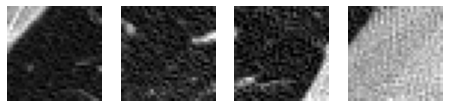

In [72]:
show_tf_batch(timg_patches[100:104,...,0].numpy(),timg_patches[100:104,...,0].numpy(),vis = 0)
timg_patches[1,...].numpy().shape

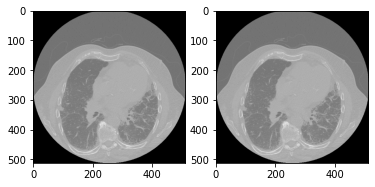

In [182]:
r_img = recover_image(timg_patches, 
                    image_size=(512, 512), 
                    n_images=(16,16))
plt.subplot(1,2,1)
plt.imshow(img.pixel_data[100], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(r_img, cmap='gray')

In [181]:
timg_patches.shape

TensorShape([256, 32, 32, 1])

In [ ]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

from keras import backend as K
import numpy as np

def extract_patches(x):
    return tf.image.extract_patches(
        x,
        (1, 3, 3, 1),
        (1, 1, 1, 1),
        (1, 1, 1, 1),
        padding="VALID"
    )

def extract_patches_inverse(x, y):
#     tf.compat.v1.disable_eager_execution()

    _x = tf.zeros_like(x)
    _y = extract_patches(_x)
    grad = tf.gradients(_y, _x)[0]
    # Divide by grad, to "average" together the overlapping patches
    # otherwise they would simply sum up
    return tf.gradients(_y, _x, grad_ys=y)[0] / grad

# Generate 10 fake images, last dimension can be different than 3
images = np.random.random((10, 28, 28, 3)).astype(np.float32)
# Extract patches
patches = extract_patches(images)
# Reconstruct image
# Notice that original images are only passed to infer the right shape
images_reconstructed = extract_patches_inverse(images, patches) 

# Compare with original (evaluating tf.Tensor into a numpy array)
# Here using Keras session
# images_r = images_reconstructed.eval(session=K.get_session())

# print (np.sum(np.square(images - images_r))) 
# 2.3820458e-11

In [2]:
import numpy

In [3]:
numpy.__version__

'1.20.3'